In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import seaborn as sns
import numpy as np
import os
import math
from scipy import stats

ModuleNotFoundError: No module named 'scipy'

In [12]:
sns.set()
sns.set_palette('pastel')

## Helpers

In [13]:
def rssi2meters(rssi, tx=-59, N=2):
  return 10 ** (-(rssi - tx) / (10 * N))

In [14]:
def meters2rssi(meters, tx=-59, N=2):
    return -10 * N * math.log10(meters) + tx

In [15]:
class KalmanFilter:
    def __init__(self, process_noise=0.1, sensor_noise=3.5, estimated_error=0, value=None):
        self.process_noise = process_noise
        self.sensor_noise = sensor_noise
        self.estimated_error = estimated_error
        self.prediction_cycles = 0
        self.value = value
        
    def get_filtered_value(self, measurement):
        if measurement is None or np.isnan(measurement):
            return measurement
        # prediction phase
        self.estimated_error += self.process_noise
        
        if self.value is None:
            self.value = measurement
        
        # measurement update
        kalman_gain = self.estimated_error / (self.estimated_error + self.sensor_noise)
        self.value = self.value + kalman_gain * (measurement - self.value)
        self.estimated_error = (1 - kalman_gain) * self.estimated_error
        
        return self.value

## Hard data

In [16]:
walk_positions = {
    0: (3.037, 18.201),
    1: (0.531, 10.962),
    2: (0.777, 5.590),
    3: (6.864, 3.642),
    4: (5.949, 9.175),
    5: (5.923, 23.852),
    6: (5.005, 35.417-6.782),
    7: (3.287, 35.417-2.177),
    8: (3.037, 18.201),
}

In [17]:
beacons_positions = {
    1: (0.252, 26.681),
    2: (9.221, 25.608),
    3: (9.197, 11.209),
    4: (0, 0)
}

In [18]:
palette = sns.color_palette('pastel', n_colors=len(beacons_positions))

## Raw Analysis

In [19]:
data_dir = 'data/exp1-museum'

In [20]:
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

In [21]:
dfs = [
    pd.read_csv(os.path.join(data_dir, csv), parse_dates=['time']).assign(dataset_index=i + 1)
    for i, csv in enumerate(csv_files)
]
size = len(dfs)
size

1

In [22]:
df = dfs[0][[
    'xp_step', 'time',
    'ESP32-1_rssi', 'ESP32-1_raw_dist', 'ESP32-1_filtered_dist',
    'ESP32-2_rssi', 'ESP32-2_raw_dist', 'ESP32-2_filtered_dist',
    'ESP32-3_rssi', 'ESP32-3_raw_dist', 'ESP32-3_filtered_dist',
    'ESP32-4_rssi', 'ESP32-4_raw_dist', 'ESP32-4_filtered_dist',
]]
df = df[(df['xp_step'] % 2 == 0) & (df['xp_step'] < len(walk_positions) * 2)]

In [23]:
df['theorical_x'] = [walk_positions[step // 2][0] for step in df['xp_step']]
df['theorical_y'] = [walk_positions[step // 2][1] for step in df['xp_step']]
df['i'] = range(len(df))

In [68]:
N = 2.8504933177828207
tx = -69

for i, pos in beacons_positions.items():
    df[f'ESP32-{i}_theorical_dist'] = [((row['theorical_x']-pos[0])**2 + (row['theorical_y']-pos[1])**2)**0.5 for _, row in df.iterrows()]
    df[f'ESP32-{i}_error_raw_dist'] = abs(df[f'ESP32-{i}_theorical_dist']-df[f'ESP32-{i}_raw_dist'])
    df[f'ESP32-{i}_error_filtered_dist'] = abs(df[f'ESP32-{i}_theorical_dist']-df[f'ESP32-{i}_filtered_dist'])
    df[f'ESP32-{i}_estimated_tx'] = df.T.apply(lambda row: 10 * N * math.log10(row[f'ESP32-{i}_theorical_dist']) + row[f'ESP32-{i}_rssi'] if row[f'ESP32-{i}_theorical_dist'] else None)
    
    df[f'ESP32-{i}_new_raw_dist'] = [rssi2meters(v, tx=tx, N=N) for v in df[f'ESP32-{i}_rssi']]

    kf = KalmanFilter()
    df[f'ESP32-{i}_new_filtered_dist'] = df[f'ESP32-{i}_new_raw_dist'].apply(lambda x: kf.get_filtered_value(x))

In [69]:
df.head(1).T

,3
xp_step,0
time,2025-04-08 15:06:42.281464
ESP32-1_rssi,-100.0
ESP32-1_raw_dist,35.481339
ESP32-1_filtered_dist,19.564771
ESP32-2_rssi,-100.0
ESP32-2_raw_dist,35.481339
ESP32-2_filtered_dist,19.999337
ESP32-3_rssi,-100.0
ESP32-3_raw_dist,35.481339


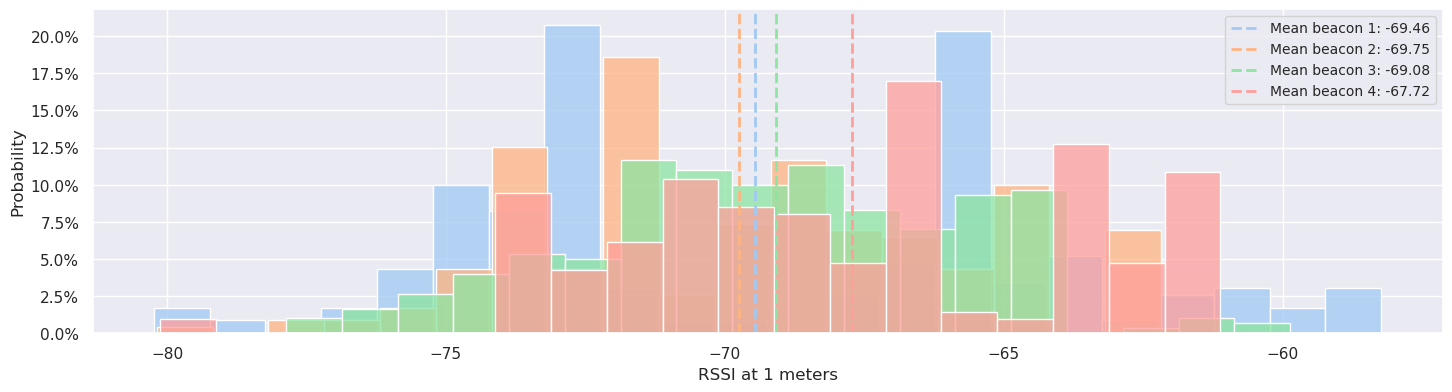

In [70]:
plt.figure(figsize=(15, 4))
plt.subplots_adjust(bottom=0.13, top=0.94, left=0.05, right=0.95)

for i in beacons_positions.keys():
    ax = sns.histplot(data=df, x=f'ESP32-{i}_estimated_tx', discrete=True, stat='probability')
    mean = df[f'ESP32-{i}_estimated_tx'].mean()
    color = palette[i-1]
    ax.axvline(x=mean, color=color, linestyle='--', linewidth=2, label=f'Mean beacon {i}: {mean:.2f}')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='best', fontsize='small')
plt.xlabel('RSSI at 1 meters')
plt.savefig('out/beacon-rssi-1m-museum.pdf')

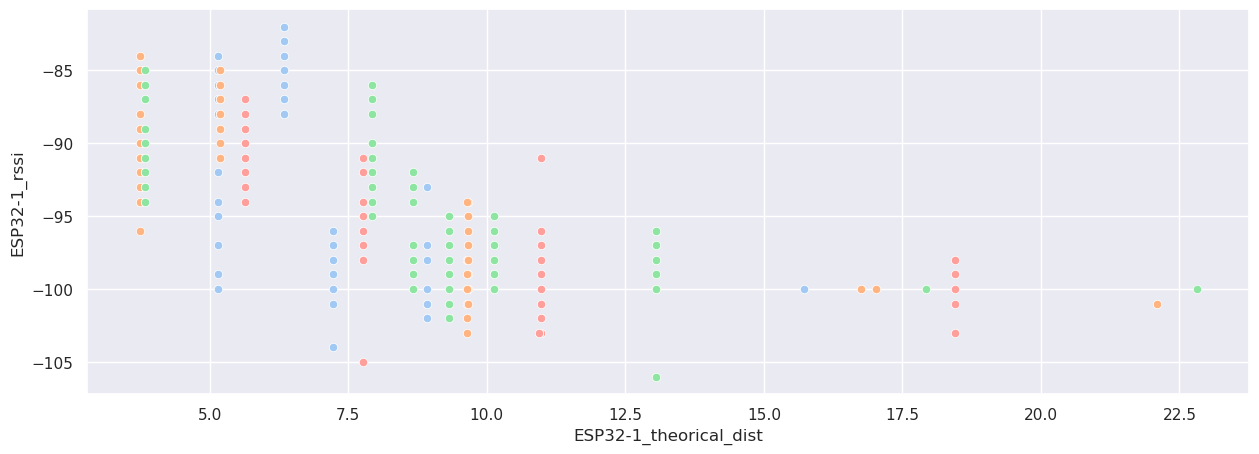

In [71]:
plt.figure(figsize=(15, 5))
for i in beacons_positions.keys():
    sns.scatterplot(data=df, x=f'ESP32-{i}_theorical_dist', y=f'ESP32-{i}_rssi')

<Axes: xlabel='i', ylabel='ESP32-3_filtered_dist'>

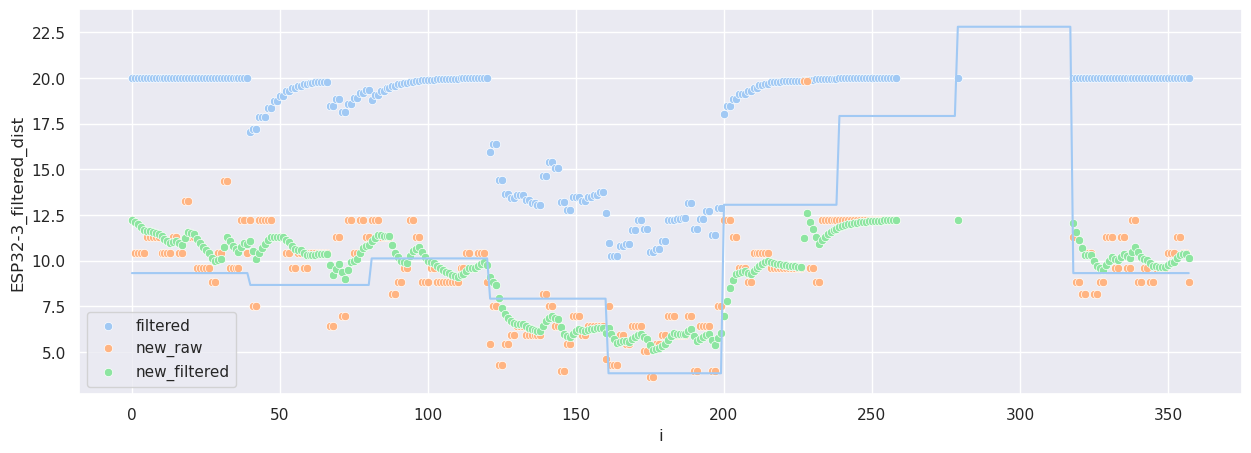

In [73]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='i', y=f'ESP32-3_filtered_dist', label='filtered')
sns.scatterplot(data=df, x='i', y=f'ESP32-3_new_raw_dist', label='new_raw')
sns.scatterplot(data=df, x='i', y=f'ESP32-3_new_filtered_dist', label='new_filtered')

sns.lineplot(data=df, x='i', y=f'ESP32-3_theorical_dist')